In [1]:
import dowhy
from dowhy import CausalModel
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from IPython.display import Image, display

import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
from sys import path
import os

for dirname, _, filenames in os.walk("../../resources/"):
    for filename in filenames:
        print(os.path.join(dirname, filename))
path.append(os.path.realpath("../../"))

from custom import functions

warnings.filterwarnings("ignore")

../../resources/allColProSol.xlsx
../../resources/dataset_a_2021.csv
../../resources/dataset_a_2021c2.csv
../../resources/dataset_a_2021v1.xlsx
../../resources/dataset_unab_ORIGINAL SIN P1.csv
../../resources/dataset_unab_P1.csv
../../resources/exitoFallidoEnviosProgramaSol.xlsx
../../resources/exitoFallidoProgramaSol.xlsx
../../resources/exitosoFallidosEnviosAllColProSol.xlsx
../../resources/exitosoFallidosEnviosAllColSol.xlsx
../../resources/exitososFallidosEnviosSol.xlsx
../../resources/Hito12sinColCeroExitosoFallidosSol.xlsx
../../resources/sinColCeroExitosoFallidosEnviosSol.xlsx
../../resources/sinColCeroExitosoFallidosSol.xlsx
../../resources/v2_hitosExitoFalloColESol1.csv
../../resources/v2_hitosExitoFalloColESol1Prograna.csv
../../resources/v2_hitosExitoFalloSol1Programa.csv
../../resources/causalidad\causalidad.dot
../../resources/causalidad\causalidad.png
../../resources/causalidad\causalidad_e29.dot
../../resources/causalidad\graph_causal_model_e29.png
../../resources/causal

In [2]:
# Read and preview data
df = pd.read_csv(
    "../../resources/v2_hitosExitoFalloColESol1.csv",
    delimiter=";",
    skipinitialspace=True,
)

In [3]:
# creando columna aprobado y con la funcion set_in_aprobado_nota poblamos la nueva columna.
df["aprobado"] = df.apply(lambda x: functions.set_in_aprobado_nota(x["sol1"]), axis=1)
# revisamos la existencia de la nueva columna.
print(df.columns)

Index(['hito1', 'hito2', 'exitosos', 'fallidos', 'e0', 'e1', 'e2', 'e3', 'e4',
       'e5', 'e6', 'e7', 'e8', 'e9', 'e10', 'e11', 'e12', 'e13', 'e14', 'e15',
       'e16', 'e17', 'e18', 'e19', 'e20', 'e21', 'e22', 'e23', 'e24', 'e25',
       'e26', 'e27', 'e28', 'e29', 'e30', 'e31', 'e32', 'e33', 'e34', 'e35',
       'e36', 'e37', 'e38', 'e39', 'e40', 'e41', 'e42', 'e43', 'e44', 'e45',
       'e46', 'e47', 'e48', 'e49', 'e50', 'e51', 'e52', 'sol1', 'aprobado'],
      dtype='object')


In [4]:
# Paso 1: Modelar un problema causal
model = CausalModel(
    data=df,
    treatment="e35",  # Variable tratada (exposición)
    outcome="aprobado",  # Variable de resultado
    common_causes=[
        "e29",
        "e3",
        "e42",
        "e13",
        "e26",
        "e18",
        "e26",
        "e18",
        "e32",
        "e10",
        "e0",
        "e4",
        "e23",
        "e7",
        "e17",
        "e25",
        "e22",
        "e8",
    ],  # Variables de causa común
)

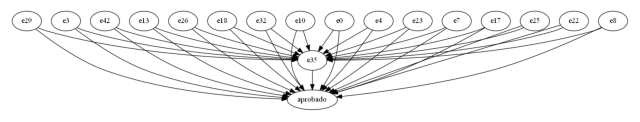

In [5]:
# Visualizar el modelo causal
model.view_model(
    layout="dot", file_name="../../resources/causalidad/graph_causal_model_e35"
)

In [6]:
# Paso 2: Identificar el estimando objetivo bajo el modelo
identified_estimand = model.identify_effect(proceed_when_unidentifiable=True)

In [7]:
# Paso 3: Estimar el efecto causal usando un método basado en árboles
estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.econml.dml.DML",
    control_value=0,
    treatment_value=1,
    target_units="ate",  # Average Treatment Effect
    method_params={
        "init_params": {
            "model_y": RandomForestRegressor(),
            "model_t": RandomForestRegressor(),
            "model_final": RandomForestRegressor(
                max_depth=10,
                min_samples_split=10,
                min_samples_leaf=5,
                random_state=1502,
                n_estimators=500,
            ),
            "featurizer": None,
        },
        "fit_params": {},
    },
)

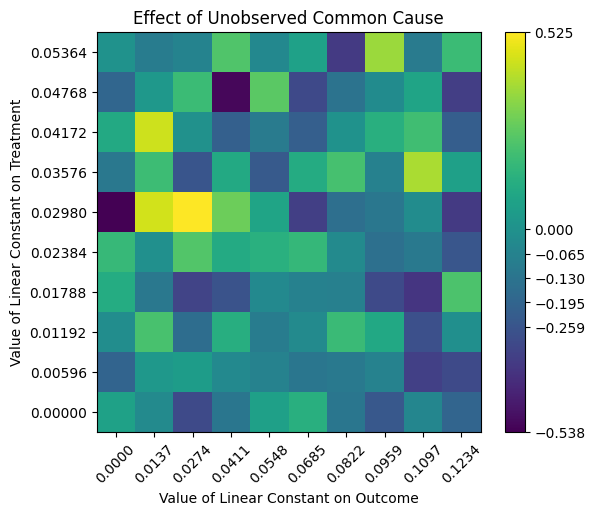

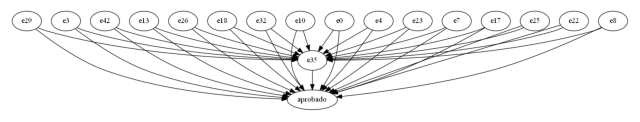

In [8]:
# Refutar el estimado obtenido con la variable de causa común no observada
refute_results_unobserved = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="add_unobserved_common_cause",
    confounders_effect_on_treatment="binary_flip",
    confounders_effect_on_outcome="binary_flip",
)

# Visualizar el modelo causal con la variable de causa común no observada
model.view_model(
    layout="dot",
    file_name="../../resources/causalidad/graph_causal_model_e35_with_unobserved",
)

In [9]:
# Paso 4: Refutar el estimado obtenido
refute_results = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="placebo_treatment_refuter",
    placebo_type="permute",
)

# Imprimir resultados RandomForestRegressor estimado de efecto causal
print("----------------------------")
print("Estimado de efecto causal:")
print(estimate.value)
print("----------------------------")

----------------------------
Estimado de efecto causal:
-0.2593687258378694
----------------------------


In [10]:
print("----------------------------")
print("¿Es aplicable la puerta trasera?")
print(estimate)
print("----------------------------")

----------------------------
¿Es aplicable la puerta trasera?
*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                                                                           
──────(E[aprobado|e32,e22,e8,e17,e0,e3,e26,e4,e7,e42,e13,e18,e25,e23,e10,e29])
d[e₃₅]                                                                        
Estimand assumption 1, Unconfoundedness: If U→{e35} and U→aprobado then P(aprobado|e35,e32,e22,e8,e17,e0,e3,e26,e4,e7,e42,e13,e18,e25,e23,e10,e29,U) = P(aprobado|e35,e32,e22,e8,e17,e0,e3,e26,e4,e7,e42,e13,e18,e25,e23,e10,e29)

## Realized estimand
b: aprobado~e35+e32+e22+e8+e17+e0+e3+e26+e4+e7+e42+e13+e18+e25+e23+e10+e29 | 
Target units: ate

## Estimate
Mean value: -0.2593687258378694
Effect estimates: [[-0.25936873]]

----------------------------


In [11]:
print("----------------------------")
print("Refutación de estimado:")
print(refute_results)
print("----------------------------")

----------------------------
Refutación de estimado:
Refute: Use a Placebo Treatment
Estimated effect:-0.2593687258378694
New effect:0.03813198621373301
p value:0.74

----------------------------
